<table style="float:left; border:none">
   <tr style="border:none; background-color: #ffffff">
       <td style="border:none">
           <a href="http://bokeh.pydata.org/">     
           <img 
               src="assets/bokeh-transparent.png" 
               style="width:50px"
           >
           </a>    
       </td>
       <td style="border:none">
           <h1>Bokeh 教程</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>A3. 使用Holoviews高级制图</h2></div>

Bokeh旨在通过Python代码构建基于浏览器的丰富，深度交互的可视化。它的语法比Matplotlib这样的老式库更加紧凑和自然，特别是在使用Charts API时。但它仍然需要一些代码才能完成比较常见的数据科学任务，如复杂的多图布局，动画和控件参数空间探索。

探索数据时，为了在Jupyter notebooks中 "即时" 生成复杂的交互式可视化，我们在Bokeh之上创建一个新库 [HoloViews](http://holoviews.org)。

HoloViews允许您使用少量元数据注释您的数据，使其即时可视化，通常无需编写任何绘图代码。HoloViews可以实现探索数据集并以交互方式从各个角度对其进行可视化处理，将用于常见任务的Bokeh代码包装到一组可配置可组合的组件中。HoloViews安装与Bokeh独立，使用命令 `conda install holoviews`，也可以和 matplotlib 一起工作。


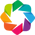

In [1]:
import holoviews as hv
import numpy as np
hv.notebook_extension('bokeh')

# A simple function

首先，让我们使用Numpy数组库来定义一个数学函数：

In [2]:
def sine(x, phase=0, freq=100):
    return np.sin((freq * x + phase))

我们将研究不同 phase 和 freq 的影响：

In [3]:
phases = np.linspace(0,2*np.pi,7)  # Explored phases
freqs = np.linspace(50,150,5)      # Explored frequencies

在特定的空间区域，通过网格采样：

In [4]:
dist = np.linspace(-0.5,0.5,81)   # Linear spatial sampling
x,y = np.meshgrid(dist, dist)
grid = (x**2+y**2)                 # 2D spatial sampling

# Succinct data visualization

借助 HoloView，我们可以立即通过Jupyter notebook中的Bokeh图观察这一简单函数，无需任何编码：

In [5]:
hv.__version__

1.9.4-x-g73c2735e7

In [6]:
hv.Image(sine(grid, freq=20))

:Image   [x,y]   (z)

我们可以简单地使用 ``+`` 将 ``Image`` and ``Curve`` 对象组合在一起，可视化二维数组（带有关联的直方图）和一维横截面：

In [7]:
grating = hv.Image(sine(grid, freq=20), label="Sine Grating")

((grating * hv.HLine(y=0)).hist() + grating.sample(y=0).relabel("Sine Wave"))

:Layout
   .AdjointLayout.Sine_Grating :AdjointLayout
      :Histogram   [z]   (z_frequency)
      :Overlay
         .Image.Sine_Grating :Image   [x,y]   (z)
         .HLine.I            :HLine   [x,y]
   .Curve.Sine_Wave            :Curve   [x]   (z)

在这里你可以看到：一个HoloViews对象不是一个真正的图表（虽然它会在Jupyter notebook请求显示时生成一个Bokeh图）；它只是数据的一个包装，并且数据可以直接处理（就像在这里使用 `sample()` 获得横截面）。 实际上，您的原始数据 *始终* 可用，您可以轻松灵活地在可视化和数值分析之间来回切换：

In [8]:
grating[0,0]

0.0

In [9]:
type(grating.data)

numpy.ndarray

这里的底层数据是原始的Numpy数组，也可以提供Python字典以及Pandas和其他数据格式。

通过对象的 `repr` 查找定位该数据所需的索引，始终可以检索底层对象和数据，即使在复杂的多图对象中也是如此：

In [10]:
layout = ((grating * hv.HLine(y=0)) + grating.sample(y=0))
print(repr(layout))
layout.Overlay.Sine_Grating.Image.Sine_Grating[0,0]

:Layout
   .Overlay.Sine_Grating :Overlay
      .Image.Sine_Grating :Image   [x,y]   (z)
      .HLine.I            :HLine   [x,y]
   .Curve.Sine_Grating   :Curve   [x]   (z)


0.0

这里的 `layout` 是整个复杂对象的名称，`Overlay.Sine_Grating` 选择第一个项目（HLine覆盖在grating上），`Image.Sine_Grating` 选择覆盖层内的grating。然后grating由'x'和'y'索引，返回值是'z'（在这种情况下几乎为零，您可以通过检查上面的曲线图查看）。

# Interactive exploration

HoloViews旨在探索复杂的数据集，通常比可以一次显示在屏幕上的数据多得多。如果您的数据维度没有布置为相邻图或覆盖图，则HoloView会自动生成覆盖剩余数据范围的滑块。例如，如果我们添加一个指示横截面位置的附加维度 `Y`，将得到 `Y` 的滑块：

In [11]:
positions = np.linspace(-0.3, 0.3, 17)

hv.HoloMap({y: (grating * hv.HLine(y)) for y in positions}, kdims='Y') + \
hv.HoloMap({y: (grating.sample(y=y))   for y in positions}, kdims='Y')

:Layout
   .HoloMap.Sine_Grating.I  :HoloMap   [Y]
      :Overlay
         .Image.Sine_Grating :Image   [x,y]   (z)
         .HLine.I            :HLine   [x,y]
   .HoloMap.Sine_Grating.II :HoloMap   [Y]
      :Curve   [x]   (z)

默认情况下，数据将被完全嵌入到输出中，允许导出为静态HTML/JavaScript用于分发，但对于参数空间过大或使用动态数据的情况，可能会通过 [DynamicMap](http://holoviews.org/Tutorials/Dynamic_Map.html) 使用动态回调即时动态地生成数据。

# 设置显示选项

如上例中 `grating` 这样的HoloViews对象，只包含数据和相关元数据，而不包含任何绘图细节。像标题和单位这样的元数据可以在创建或随后设置在对象上，如上例的 `label` 和 `relabel` 所示。

可视化的其他属性，如果只和视图相关，和实际数据无关，则并不存储在HoloViews对象中，而是存储在一个单独的数据结构中。为了便于在 notebook 中控制这些选项，提供了一些特殊的语法：

In [12]:
%%opts Image (cmap='RdYlGn') Curve (color='b' line_dash="dotted") HLine (line_color='white' line_width=9)
((grating * hv.HLine(y=0)).hist() + grating.sample(y=0))

:Layout
   .AdjointLayout.Sine_Grating :AdjointLayout
      :Histogram   [z]   (z_frequency)
      :Overlay
         .Image.Sine_Grating :Image   [x,y]   (z)
         .HLine.I            :HLine   [x,y]
   .Curve.Sine_Grating         :Curve   [x]   (z)

这种特殊的 “魔术” 语法的一个优点是在Jupyter notebook中名称和值可以用tab补全（尝试下！）。这里的圆括号 '(' 表示后端特定的选项；这些选项通常直接传递给Bokeh。HoloViews处理的选项使用方括号 '[' 指定。上例的 `%%opts` 命令仅影响该单元格中的对象，而下面的 `%opts` 命令将影响整个文档的其余部分。

In [13]:
%opts Points (size=3)

### EXERCISE: Try changing various parameters in the above plot, using tab completion to discover the names and values

当然，您可以使用标准Python语法来表达任何选项设置。但是由于技术上的原因，语法不够简洁，更重要的是，它将显示选项与实际数据对象混合在一起：

In [14]:
grating(options={'Image':{'style':{'cmap':'RdGy'}}})

:Image   [x,y]   (z)

上例使用的 `%opts`/`%%opts` 语法既不那么冗长，也有助于把样式信息与更重要的数据和元数据分隔开，以便在处理数据时可以忽略样式。

## Normalizing your data

HoloViews旨在让您轻松理解您的数据。例如，考虑两个幅度非常不同的圆形波：

In [15]:
comparison = hv.Image(sine(grid)) + hv.Image(sine(grid, phase=np.pi)*0.02)

HoloViews确保默认情况下可以看到这些差异，通过标准化所有显示在一起的相同类型的元素，甚至在动画的各个帧之间：

In [16]:
%%opts Image (cmap='gray')
comparison = hv.Image(sine(grid)) + hv.Image(sine(grid, phase=np.pi)*0.02)
comparison

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

这个默认的可视化表明这两种模式的幅度差别很大。但是，很难看到 **B** 中低振幅波的结构。如果您想关注空间结构而不是振幅，可以指示HoloViews分别对不同轴上的数据进行标准化：

In [17]:
%%opts Image {+axiswise} (cmap='gray')
comparison

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

同样，您可以通过 ``+framewise`` 来指示它对动画的每帧数据进行规范化处理，而不是像所有帧一样默认处理。与任何其他自定义一样，即使在复杂的多重子图布局中，您也可以始终指定要将自定义应用于哪个特定元素。

# 外部数据源

为了展示HoloViews与标准Bokeh API的不同之处，让我们重新看一下教程1中的 `iris` 示例。

In [18]:
from bokeh.sampledata.iris import flowers
flowers.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

使用通常的Bokeh Charts API绘制该数据可以快速地给出可视化，例如，通过键入：

```
show(Scatter(flowers, x='petal_length', y='petal_width'))
```

但是，结果仅限于少数标准配置，您必须使用完整的Bokeh API才能获得更复杂的可视化效果。使用HoloViews，就像使用Charts API创建简单图一样容易：

In [19]:
hv.Points(flowers, kdims=['petal_length','petal_width'], vdims=[])

:Points   [petal_length,petal_width]

或者更复杂的图：

In [20]:
%opts NdOverlay [legend_position='top_left']
irises = hv.Dataset(flowers).to(hv.Points, kdims=['petal_length','petal_width'], groupby=['species'])

irises.overlay()

:NdOverlay   [species]
   :Points   [petal_length,petal_width]

但是现在，您可以非常轻松地生成控件、动画和布局。例如，如果不使用 `.overlay()` 告诉 HoloViews 如何处理 species，它将自动成为一个构件，而不必重新定义组成该图的任何东西：

In [21]:
irises.overlay() + irises

:Layout
   .NdOverlay.I :NdOverlay   [species]
      :Points   [petal_length,petal_width]
   .HoloMap.I   :HoloMap   [species]
      :Points   [petal_length,petal_width]

在这里我们看到，前面的图已经被放在了左边，说明在HoloViews中布局数据很简单。您还可以很简单地告诉 HoloViews 并排布置 species 数据：

In [22]:
irises.layout()

:NdLayout   [species]
   :Points   [petal_length,petal_width]

正如你所看到的，HoloViews具有 Charts API类似的功能，但是允许从更高级别操作。相反，Charts API直接为您提供一个Bokeh图，可以使用Bokeh的低级函数进行绘图，从而获得比HoloView支持更精确（但繁琐）的自定义。

# 更多信息

如果您有兴趣在工作中使用 HoloViews，请查看 [holoviews.org](http://holoviews.org) 上的大量教程以及 [geo.holoviews.org](http://geo.holoviews.org/) 上的地理应用。这些教程将详细介绍以上所示的所有内容以及如何 [导出可重现工作流的数据](http://holoviews.org/Tutorials/Exporting.html)，如何使用类似Pandas Dataframes的 [列式数据](http://holoviews.org/Tutorials/Columnar_Data.html)，如何使用其他 [可用的绘图类型](http://holoviews.org/Tutorials/Elements.html)，如何使用其他 [可用的容器类型](http://holoviews.org/Tutorials/Composing_Data.html)。